In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

## What is Entropy?

Imagine that Alice and Bob want to communicate with each other but they can only do so by sending a finite sequence of binary digits. First Alice wants to send to Bob the results of four die tosses "1461". Since each toss can yield six distinct results, Alice initially thinks that she can send a sequence of binary digits to inform Bob that the first toss was 1. She sends him the message 1. For the second toss, she sends him the message 0001. You can read this message as answering the following yes or no questions:

- "Was it 1?" $\rightarrow$ No
- "Was it 2?" $\rightarrow$ No
- "Was it 3?" $\rightarrow$ No
- "Was it 4?" $\rightarrow$ YES!

The message Alice needs to send in this case is: 100010000011. 12 Binary digits in total.

Bear in mind that if Alice had only to inform Bob about the result of one toss she could omit the 1 at the end of the string, since Bob would be able to deduce the correct number. Nonetheless, when she tries to inform him about multiple tosses, 1 is very important as it enables Bob to distinguish where the message for the first toss ends and where the second begins. 

The algorithm is fairly straightforward. Bob can read that message by calculating the number of zeros in front of 1, and that way he can guess the correct number of the die toss. However, at first glance, this doesn't seem a very efficient to communicate. Surely, Alice thinks, we can do better than that - and indeed we can.

In [3]:
def encode_messagel(tosses : str) -> str:
    "The encoding function which Alice utilises to inform Bob about the die tosses."
    return ''.join([ "0"*(int(result)-1) + "1" for result in tosses])
    
encode_messagel("1462")

'1000100000101'

In [4]:
def decode_messagel(encoded_msg : str) -> str:
    "Bob's decoding function"
    return ''.join([str(len(msg) + 1) for msg in encoded_msg[:-1].split('1')])

for num in range(1000,9000):
    message = str(num).replace('0','')
    assert decode_messagel(encode_messagel(message)) == message

In [5]:
decode_messagel(encode_messagel("4324234234"))

'4324234234'

By utilizing this algorithm in the best case scenario Alice would need m binary digits to send m die tosses and in the worst case scenario 6m digits. On average she would need 3.5m binary digits to transfer the message to Bob.

Data compression is the process of encoding information using fewer bits than the original representation. 

Any particular compression is either lossy or lossless. 

- Lossless compression reduces bits by identifying and eliminating statistical redundancy. No information is lost in lossless compression.
- Lossy compression reduces bits by removing unnecessary or less important information.

### Divide & Conquer

Alice decides to change her encoding algorithm. She thinks that perhaps she needs to exchange the way the questions are being asked. 

Instead of is it equal to questions, we may use is it less than questions.

In [6]:
def encode(toss:int , alphabet) -> str:
    mid = len(alphabet)//2
    message = ''
    
    if mid == 0:
        return ''
    
    if toss < alphabet[mid]:
        return "1" + encode(toss , alphabet[:mid])
    else:
        return "0" + encode(toss , alphabet[mid:])
    

    
def encode_message(tosses:str , alphabet) -> str:
    return ''.join([encode(int(toss) , alphabet) for toss in tosses])
        

alphabet = [1,2,3,4,5,6]

encode_message("52" , np.arange(1,6,1))       

'00010'

In [7]:
np.log(5)/np.log(2) + 2

4.321928094887362

In [8]:
alphabet = np.arange(1,20,1)
for a in alphabet:
    print(encode(a,alphabet) , f"{np.log(20)/np.log(2):.2f}")

1111 4.32
1110 4.32
1101 4.32
1100 4.32
1011 4.32
1010 4.32
1001 4.32
10001 4.32
10000 4.32
0111 4.32
0110 4.32
0101 4.32
01001 4.32
01000 4.32
0011 4.32
0010 4.32
0001 4.32
00001 4.32
00000 4.32


## Implementing the Die toss random generator

In [9]:
from random import random

def generate_toss(probabilities):
    total = 0
    roll = random()
    for i , prob in enumerate(probabilities):
        if roll <= total + prob:
            return i + 1
        total += prob
        
generate_toss([1/6]*6)

2

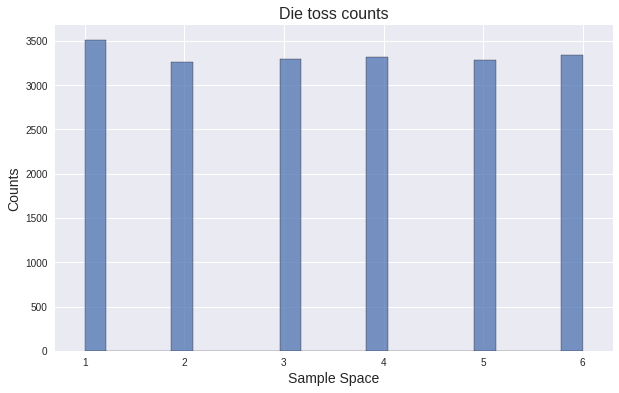

In [77]:
actualizations = np.array([generate_toss([1/6]*6) for _ in range(20000)])
sample_average = actualizations.mean()

with plt.style.context('seaborn'):
    fig , ax = plt.subplots(nrows = 1 , ncols = 1 , figsize = (10,6))
    sns.histplot(data = actualizations)
    plt.title("Die toss counts" , size = 16)
    plt.xlabel("Sample Space" , size = 14)
    plt.ylabel("Counts" , size = 14)
    plt.annotate(  f"{sample_average=:.2f}", xy = (5.6,4500) , size = 11)
    plt.xlim(0.7,6.3)

In [90]:
probs = [1/16 , 2/16 , 1/16 , 1/16 , 4/16 , 7/16]
sum(probs)

1.0



\begin{equation}
\begin{split}
& \sum_{i=1}^{6} p_{i} = 1 \\
& \sum_{i=1}^{6} i p_{i} = 4.7 \\
\end{split}
\end{equation}

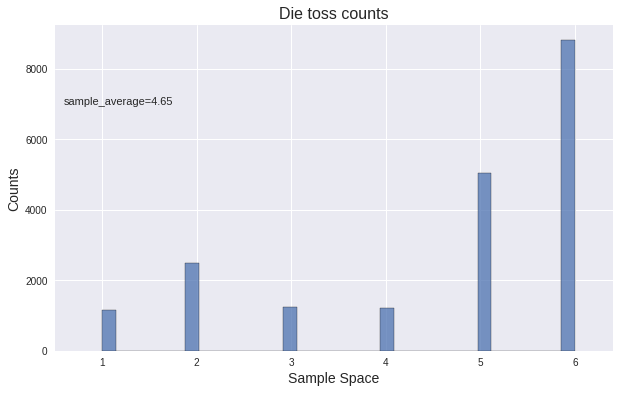

In [92]:
actualizations = np.array([generate_toss(probs) for _ in range(20000)])
sample_average = actualizations.mean()

with plt.style.context('seaborn'):
    fig , ax = plt.subplots(nrows = 1 , ncols = 1 , figsize = (10,6))
    sns.histplot(actualizations)
    plt.title("Die toss counts" , size = 16)
    plt.xlabel("Sample Space" , size = 14)
    plt.ylabel("Counts" , size = 14)
    plt.annotate(  f"{sample_average=:.2f}", xy = (0.6,7000) , size = 11)
    plt.xlim(0.5,6.4)

Let's run our random experiment. We will randomly generate die tosses with a varying probability density function and we will consequently binary encode the results of the tosses.

In [10]:
def run_experiment(prob , alphabet):
    toss = generate_toss(prob)
    encoded = encode(toss , alphabet)
    return encoded

run_experiment([1/6]*6 , [1,2,3,4,5,6])

'100'

In [11]:
alphabet = [1,2,3,4,5,6]
for a in alphabet:
    print(a , ":", encode(a , alphabet))

1 : 11
2 : 101
3 : 100
4 : 01
5 : 001
6 : 000


We notice that 4 out of 6 results will require 3 digits to binary encode them wheres 2 will only need 2 binary digits. Hence, in the case of equiprobable results, the average length will be given by

$3*(4/6) + 2*(2/6) = 16/6 = 8/3$

In [12]:
8/3

2.6666666666666665

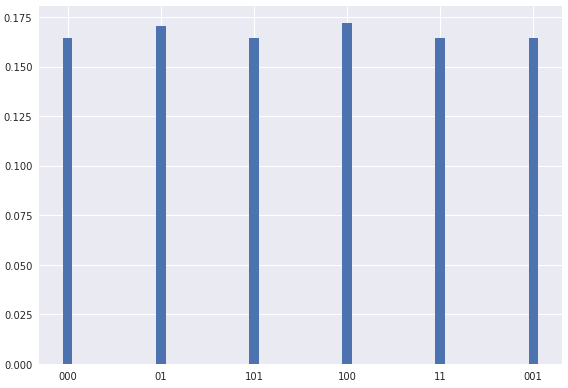

In [13]:
prob = [1/6]*6
alphabet = [1,2,3,4,5,6]
iterations = 10000

many_samples = [run_experiment(prob , alphabet) for _ in range(iterations)]
value_counts = {a : many_samples.count(a)/iterations for a in list(set(many_samples))}

with plt.style.context('seaborn'):
    plt.bar(value_counts.keys() , value_counts.values() ,  width = 0.1)
    plt.tight_layout()

It's time now to simulate the average number of binary digits that we need to use to encode the die toss messages.

In [14]:
import math

def shannon_entropy(p):
    entropy = 0
    for q in p:
        try:
            entropy += - q *  math.log(q)/math.log(2)
        except ValueError:
            continue
    return entropy 

In [15]:
alphabet = [1,2,3,4,5,6]

np.log(len(alphabet))/np.log(2)

2.584962500721156

In [16]:
gibbs = np.array([1/6]*6)
shannon_entropy(gibbs)

2.584962500721156

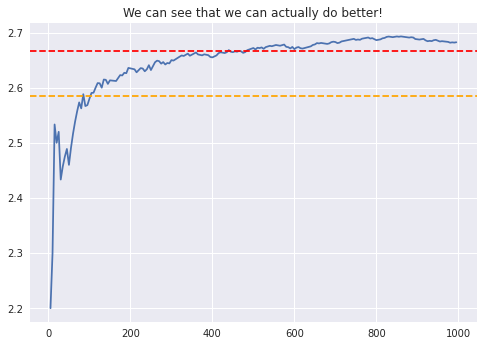

In [17]:
iterations = 1000
gibbs = np.array([1/6]*6)
alphabet = [1,2,3,4,5,6]

def run_experiment(prob , alphabet):
    toss = generate_toss(prob)
    encoded = encode(toss , alphabet)
    return len(encoded)

results = np.array([run_experiment(gibbs , alphabet) for _ in range(iterations)])
sequence_of_means = np.array([results[:i].mean() for i in range(5,iterations,5)])
max_ent = shannon_entropy(gibbs)

with plt.style.context('seaborn'):
    plt.plot(np.arange(5,iterations,5), sequence_of_means)
    plt.axhline(max_ent , linestyle = '--' , color = 'orange')
    plt.axhline(8/3,  linestyle = '--' , color = 'red')
    plt.title("We can see that we can actually do better!")

## Implementing Maximum Entropy Model

In [18]:
from maxent import MaxEnt

In [19]:
model = MaxEnt()
payoffs = np.arange(1,7,1)
model.payoffs = payoffs
sample_mean = 4.6

model.fit(sample_mean , verbose = True)
model.predict_proba()

iteration 0:	-0.3771428571428571	0.08604651768706262
iteration 1:	-0.41486123949437415	0.001991950294029543
iteration 2:	-0.41577695237036033	1.1891268396624355e-06
iteration 3:	-0.41577749967340233	4.2454928461665986e-13


array([0.04637199, 0.070279  , 0.10651125, 0.16142297, 0.24464436,
       0.37077043])

In [20]:
model.predict()

6

In [21]:
def getGibbsDistribution(payoffs : np.ndarray , partitions : int = 20) -> pd.DataFrame:
    model = MaxEnt()
    payoffs.sort()
    model.payoffs = payoffs
    total_events = len(payoffs)
    
    probabilities = None
    for sample_mean in np.linspace(payoffs[0],payoffs[-1], partitions):
        model.fit(sample_mean)
        gibbs_probabilities = model.predict_proba()
        gibbs_probabilities = np.append(gibbs_probabilities , [sample_mean] , axis = 0)
        if probabilities is None:
            probabilities = gibbs_probabilities
        else:
            probabilities = np.vstack([probabilities , gibbs_probabilities])

    probabilities = pd.DataFrame(probabilities , 
                                 columns = [f"{i}" for i in range(1,total_events + 1,1)] +  ["sample_mean"])
    probabilities.index.name = 'Gibbs distribution'
    probabilities.columns.name = 'events'
    
    return probabilities

total_events = 6
payoffs = np.arange(1, total_events+1, 1)
np.random.shuffle(payoffs)
probabilities_df = getGibbsDistribution(payoffs)
probabilities_df.style.format('{:.5f}').background_gradient(cmap = 'summer')

events,1,2,3,4,5,6,sample_mean
Gibbs distribution,,,,,,,
0,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
1,0.79142,0.16512,0.03445,0.00719,0.00150,0.00031,1.26316
2,0.65169,0.22776,0.07960,0.02782,0.00972,0.00340,1.52632
3,0.54693,0.25056,0.11479,0.05259,0.02409,0.01104,1.78947
4,0.46245,0.25454,0.14010,0.07711,0.04244,0.02336,2.05263
5,0.39135,0.24815,0.15735,0.09977,0.06326,0.04011,2.31579
6,0.32994,0.23546,0.16803,0.11992,0.08558,0.06107,2.57895
7,0.27607,0.21868,0.17323,0.13722,0.10870,0.08610,2.84211
8,0.22839,0.19917,0.17369,0.15147,0.13209,0.11519,3.10526


In [22]:
model = MaxEnt()
sample_space = 3
payoffs = np.arange(1,sample_space + 1 , 1)
model.payoffs = payoffs

probabilities_df = getGibbsDistribution(payoffs)
probabilities_df.style.format('{:.5f}').background_gradient(cmap = 'summer')

events,1,2,3,sample_mean
Gibbs distribution,,,,
0,1.00000,0.00000,0.00000,1.00000
1,0.90333,0.08808,0.00859,1.10526
2,0.81815,0.15317,0.02868,1.21053
3,0.74026,0.20369,0.05605,1.31579
4,0.66773,0.24348,0.08878,1.42105
5,0.59951,0.27466,0.12583,1.52632
6,0.53497,0.29849,0.16654,1.63158
7,0.47368,0.31579,0.21053,1.73684
8,0.41541,0.32707,0.25752,1.84211


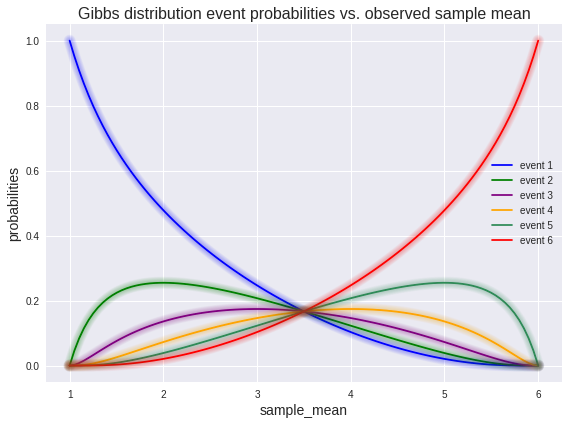

In [96]:
import mplcyberpunk as mpl

model = MaxEnt()
sample_space = 6
payoffs = np.arange(1,sample_space + 1 , 1)
model.payoffs = payoffs
probabilities_df = getGibbsDistribution(payoffs , partitions = 100)


with plt.style.context('seaborn'):
    fig , ax = plt.subplots(nrows = 1 , ncols = 1 , figsize = (8,6) , tight_layout = True)
    colors = ['blue','green','purple','orange','seagreen','red']
    for i in range(6):
        ax.plot(probabilities_df.sample_mean , 
                     probabilities_df.iloc[:,i] , 
                     color = colors[i] , alpha = 1, label = f"event {i+1}")
    ax.set_title("Gibbs distribution event probabilities vs. observed sample mean" , 
                 size = 16 )
    ax.set_xlabel("sample_mean" , size = 14 )
    ax.set_ylabel("probabilities" , size = 14 )
    ax.legend(loc=0)
mpl.make_lines_glow()

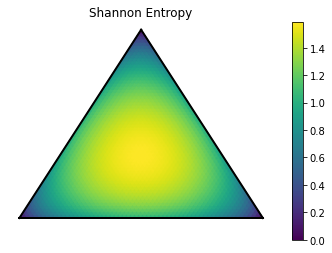

In [140]:
import matplotlib.pyplot as plt
import ternary

scale = 60
figure, tax = ternary.figure(scale=scale )
tax.heatmapf(shannon_entropy, boundary=True, style="triangular")
tax.boundary(linewidth=2.0)
tax.set_title("Shannon Entropy")
tax.get_axes().axis('off')
tax.show()

In [141]:
gibbs = probabilities_df.to_numpy()
for val in gibbs:
    print(val[0],val[1],val[-1])

0.9999999999902073 9.792744989924042e-12 1.0
0.980183199927359 0.019431579943261754 1.02020202020202
0.9610576779554122 0.03748060368490176 1.0404040404040404
0.9425268579556012 0.0543402234827371 1.0606060606060606
0.9245161787462761 0.07015956169936712 1.0808080808080809
0.9069666323843587 0.08505663422040648 1.101010101010101
0.8898305593069797 0.099126760173903 1.121212121212121
0.8730688049187594 0.11244824874833952 1.1414141414141414
0.856648734254189 0.12508636987546037 1.1616161616161615
0.8405428076324238 0.13709620291697044 1.1818181818181819
0.8247275347246587 0.14852472853048085 1.202020202020202
0.8091826908167332 0.15941239613833322 1.2222222222222223
0.7938907190819173 0.16979431941104006 1.2424242424242424
0.7788362674543752 0.179701202464861 1.2626262626262625
0.7640058248870176 0.18916006739766433 1.2828282828282829
0.7493874319813546 0.19819483300698554 1.303030303030303
0.734970448243914 0.2068267802798481 1.3232323232323233
0.7207453629675227 0.21507493063061103 1.

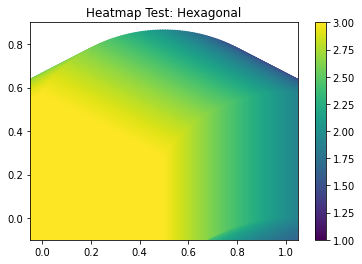

In [142]:
gibbs = probabilities_df.to_numpy()
gibbs = { ( val[0] , val[1] , val[2] ) : val[-1] for val in gibbs }

figure, tax = ternary.figure(scale=1)
tax.heatmap(gibbs , style = 'h')
tax.set_title("Heatmap Test: Hexagonal")

\begin{equation}
X = 
\begin{cases}
x_{1} , \text{ with probability } p_{1} \\
x_{2} , \text{ with probability } p_{2} \\
\dots \dots \dots \\
x_{n} , \text{ with probability } p_{n} 
\end{cases}
\end{equation}

\begin{equation}
f_{1} ( X ) , \dots , f_{j} ( X ) 
\end{equation}

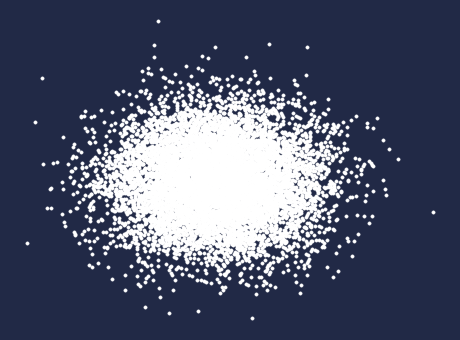

In [97]:
import seaborn as sns
data = np.random.normal(size = (10000 , 2))
X = data[:,0]
Y = data[:,1]

with plt.style.context('cyberpunk'):
    fig , ax = plt.subplots(nrows = 1 , ncols = 1 , figsize = (8,6))
    sns.scatterplot(x = X, y = Y , ax = ax , color = 'white' , s = 12)
    
    # Hide
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])